#Load data and model

In [25]:
!pip install python-binance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
import tensorflow as tf
keras = tf.keras
 
apiKey = "***"
secretKey = "***"
 
client = Client(apiKey, secretKey)

symbol = 'ETHUSDT'
 
currency = client.get_historical_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1HOUR, start_str="1 month ago UTC")
 
currency = pd.DataFrame(currency, columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume',
                                  'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
 
currency['Open time'] = pd.to_datetime(currency['Open time'], unit='ms')
 
currency.set_index('Open time', inplace = True)
currency['Close'] = currency['Close'].astype(float)
currency['Volume'] = currency['Volume'].astype(float)
currency['Open'] = currency['Open'].astype(float)
currency['High'] = currency['High'].astype(float)
currency['Low'] = currency['Low'].astype(float)
currency = currency.drop(currency[['Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']], 1)
  
data = currency.filter(['Close'])
data = data[:-1]
dataset = data.values
series = dataset[:,0]

model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ETHUSDT-1H-model.h5")

#Make prediction

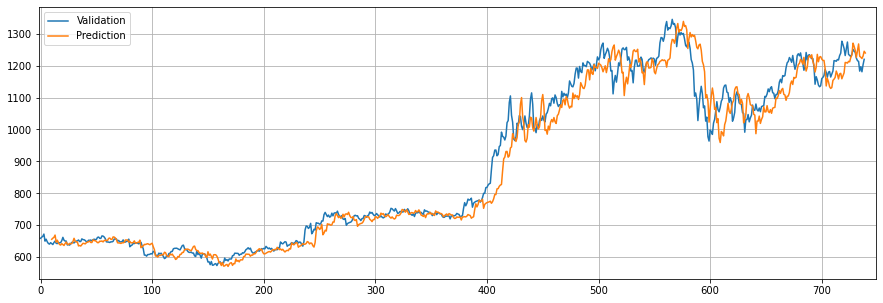

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
 
window_size = 10
forecast = model_forecast(model, series[:,  np.newaxis], window_size)
#forecast = forecast[int(len(series)*0.8) - window_size:, -1, 0]
 
a = len(series) - len(forecast)
a = np.arange(a, len(series)) + 1
plt.figure(figsize=(15,5))
plt.plot(series, label="Validation")
plt.plot(a, forecast[:,0,0], label="Prediction")
plt.xlim(len(series) - len(forecast) - 10,len(series)+10)
#plt.ylim(1000,1200)
plt.legend()
plt.grid()

In [26]:
future = series
future = np.append(future, forecast[-1:])
 
i = 0
for i in range(24):
  future_predictions = []
  future_predictions = model_forecast(model, future[:, np.newaxis], 10)
  future = np.append(future, future_predictions[-1:,0,0])
  
  #print(future_predictions[-1:,0,0])
 
#print('-----------')
#print(future[-5:])

In [27]:
h = 0
td = len(future) - len(series)
future_time = data.index
for h in range(td):
  a = data.index[-1:] + pd.Timedelta(hours=h)
  future_time = future_time.append(a)

 
h = 0
td = len(future_predictions) - len(series)
future_predictions_time = data.index
for h in range(td):
  a = data.index[-1:] + pd.Timedelta(hours=h)
  future_predictions_time = future_predictions_time.append(a)

                       Close
Open time                   
2021-01-17 11:00:00  1219.52
---------------------------
Next close price:  1230.5616
---------------------------


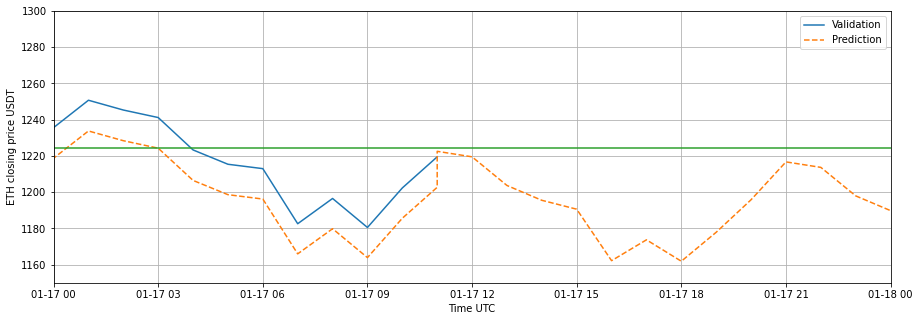

In [32]:
start_timerange = pd.Timestamp('2021-01-17')
end_timerange = pd.Timestamp('2021-01-18')
y_lim_min = 1150
y_lim_max = 1300

diff = data.Close[-1:] - future_predictions[-i,0,0]
 
plt.figure(figsize=(15,5))
plt.plot(data.index, series, label="Validation")
plt.plot(future_predictions_time, future_predictions[:,0,0] + diff[0], label="Prediction", linestyle="dashed")
#plt.plot(future_time, future, label="Future", linestyle="dotted")
plt.plot([start_timerange, end_timerange], [1224.17, 1224.17])
plt.xlim(start_timerange, end_timerange)
plt.ylim(y_lim_min,y_lim_max)
plt.legend()
plt.xlabel('Time UTC')
plt.ylabel('ETH closing price USDT')
plt.grid()
 
print(data[-1:])
print("---------------------------")
print('Next close price: ', future_predictions[-i,0,0])
print("---------------------------")